In [101]:
from torch_geometric.datasets import Amazon
from torch_geometric.transforms import NormalizeFeatures, RandomNodeSplit
from torch_geometric.utils.convert import to_networkx
from torch_geometric.utils import homophily
import networkx as nx
from tqdm.notebook import tqdm
from utils import *
import pandas as pd
import multiprocessing as mp
from tqdm.contrib.concurrent import process_map
from functools import partial
import pickle as pkl
import os

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
dataset = Amazon('data/', 'Computers', pre_transform=RandomNodeSplit(split='train_rest', num_val=1000, num_test=10000))
data = dataset[0]
test_subgraph = data.subgraph(data.test_mask)
test_subgraph

Data(x=[12000, 767], edge_index=[2, 375216], y=[12000], train_mask=[12000], val_mask=[12000], test_mask=[12000])

In [103]:
data.train_mask.sum()

tensor(752)

In [104]:
homophily(data.edge_index, data.y, method='node')

0.7853084206581116

In [105]:
G = to_networkx(test_subgraph).to_undirected()

In [106]:
G

In [107]:
def get_nbhd_weights(G, node, k, scheme='unif'):
    # Get dict containing nodes -> shortest path to node (i.e. depth).
    node_depth_map = pd.Series(nx.single_source_shortest_path_length(G, node, cutoff=k), name='distance')
    node_depth_map.index.name = 'node_id'
    node_depth_map = node_depth_map.drop(node) # Remove the node itself from list.
    node_depth_map = node_depth_map.reset_index()

    if scheme == 'geom':
        node_depth_map['weight'] = (0.5)**(node_depth_map['distance'] - 1)  # Weight =
    elif scheme == 'linear':
        node_depth_map['weight'] = 1 / node_depth_map['distance']
    else:
        node_depth_map['weight'] = 1
    return node_depth_map

In [108]:
# exp_path = 'experiments/01-11-2022_19-13-44_Computers' #- SAGE MEAN WORKING
# exp_path = 'experiments/01-11-2022_19-19-38_Computers' ## 0.765 accuracy
exp_path = 'experiments/01-11-2022_19-51-57_Computers_SHADOW'  # 0.816 accuracy
preds_path = os.path.join(exp_path, 'preds.pkl')
with open(preds_path, 'rb') as f:
    preds = pkl.load(f)
# preds = preds[lcc_nodes]
# test_x = test_subgraph.x[lcc_nodes].numpy()
# test_y = test_subgraph.y[lcc_nodes].numpy()
preds = pd.DataFrame(preds)
test_x = pd.DataFrame(data.x[data.test_mask].numpy())
test_y = pd.DataFrame(data.y[data.test_mask].numpy())

print(len(preds))
print(len(test_x))
print(len(test_y))

12000
12000
12000


In [109]:
probs = test_y.value_counts() / len(test_y)
probs.name = 'Proportion'
probs.index.name = 'Class'
probs
sum(probs**2)

0.20821679166666668

In [110]:
preds

,0,1,2,3,4,5,6,7,8,9
0,9.314415e-07,1.895561e-03,1.758353e-09,1.680594e-07,0.998090,3.981276e-08,2.203789e-07,5.027668e-06,7.839744e-06,8.139605e-12
1,3.370992e-09,1.430191e-09,1.027313e-11,6.097097e-07,0.999994,2.039296e-11,4.308239e-11,7.982651e-11,5.196885e-06,2.215572e-16
2,2.505150e-06,1.192763e-02,2.895200e-06,3.756925e-06,0.034592,9.627441e-07,2.709089e-03,6.210051e-06,9.505802e-01,1.751225e-04
3,9.063409e-08,5.029519e-04,2.165838e-07,5.439318e-08,0.000778,2.154828e-07,1.128614e-01,5.370282e-06,8.855563e-01,2.949232e-04
4,2.256134e-07,6.810711e-02,1.190744e-06,3.839542e-07,0.506895,3.445196e-06,3.255589e-01,1.939280e-06,9.942848e-02,2.790577e-06
...,...,...,...,...,...,...,...,...,...,...
11995,1.033726e-03,7.595239e-04,8.264633e-01,7.696816e-05,0.009015,4.801381e-04,4.012368e-03,1.552429e-01,2.842659e-03,7.350520e-05
11996,1.853821e-23,9.999892e-01,3.530957e-18,3.250961e-17,0.000011,1.281000e-19,1.676481e-13,4.860910e-10,3.024906e-09,9.543915e-19
11997,4.048891e-09,9.007445e-04,1.069198e-06,4.542002e-06,0.000006,6.663008e-07,2.184223e-02,3.879838e-06,9.764723e-01,7.684864e-04
11998,4.267602e-08,5.172061e-07,1.668269e-14,5.505171e-10,0.998899,7.954962e-15,3.774112e-12,1.683424e-13,1.100793e-03,7.852388e-16


In [111]:
G.number_of_nodes()

12000

In [112]:
## Compute the NAPS prediction set for each node in advance.
alpha = 0.1
cutoff = 50
quantiles_nb = []
def calibrate_nbhd(node, scheme='unif'):
    nbs = get_nbhd_weights(G, node, k=2, scheme=scheme)
    nb_ids = nbs['node_id'].values
    weights = nbs['weight'].values
    if cutoff <= len(nb_ids):
        quantile = calibrate_weighted(preds.loc[nb_ids].values,
                             np.squeeze(test_y.loc[nb_ids].values),
                                      weights, alpha)
        return {node: quantile}
# calibrate_nbhd(0)
# quantiles_nb = process_map(calibrate_nbhd, list(G.nodes), max_workers=12)

In [113]:
def precompute_naps_sets(scheme):
    f = partial(calibrate_nbhd, scheme=scheme)
    quantiles_nb = process_map(f, list(G.nodes), max_workers=12)
    nz = [p for p in quantiles_nb if p is not None]
    res = {}
    for p in nz:
        res.update(p)
    nbhd_quantiles = pd.Series(res, name='quantile')
    nbhd_quantiles
    lcc_nodes = nbhd_quantiles.index.values
    sets_nb = predict(preds.loc[lcc_nodes].values, nbhd_quantiles.values[:, None])
    sets_nb = pd.Series(sets_nb, index=lcc_nodes, name='set')
    sets_nb = pd.DataFrame(sets_nb)
    sets_nb['set_size'] = sets_nb['set'].apply(len)
    sets_nb['covers'] = [test_y.loc[i].values in sets_nb.loc[i, 'set'] for i in sets_nb.index.values]
    return sets_nb, lcc_nodes

In [114]:
naps_sets, lcc_nodes = precompute_naps_sets('unif')
napsl_sets, _ = precompute_naps_sets('linear')
napsg_sets, _ = precompute_naps_sets('geom')

/tmp/ipykernel_66460/3871286286.py:3: TqdmWarning: Iterable length 12000 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  quantiles_nb = process_map(f, list(G.nodes), max_workers=12)


  0%|          | 0/12000 [00:00<?, ?it/s]

/tmp/ipykernel_66460/3871286286.py:3: TqdmWarning: Iterable length 12000 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  quantiles_nb = process_map(f, list(G.nodes), max_workers=12)


  0%|          | 0/12000 [00:00<?, ?it/s]

/tmp/ipykernel_66460/3871286286.py:3: TqdmWarning: Iterable length 12000 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  quantiles_nb = process_map(f, list(G.nodes), max_workers=12)


  0%|          | 0/12000 [00:00<?, ?it/s]

In [115]:
naps_sets.groupby('set_size').count()

,set,covers
set_size,,
0,285,285
1,7455,7455
2,1559,1559
3,657,657
4,330,330
5,270,270
6,221,221
7,133,133
8,88,88


In [116]:
n_trials = 100
n_eval = 1000
sccv_bins = [-1, 1, 3, 15]

In [117]:
naps_stats = []
napsl_stats = []
napsg_stats = []
full_stats = []
# with mp.Pool(12) as p:
for k in tqdm(range(n_trials)):
    ## Sample the prediction nodes.
    pred_nodes = np.random.choice(lcc_nodes, size=n_eval, replace=False)
    # Neighbourhood calibration is pre-computed, so just get prediction sets for them.
    naps_stats.append(evaluate_predictions(naps_sets.loc[pred_nodes, 'set'].values,
                                         test_x.loc[pred_nodes].values,
                                         np.squeeze(test_y.loc[pred_nodes].values), alpha, sccv_bins
                                         ))
    napsl_stats.append(evaluate_predictions(napsl_sets.loc[pred_nodes, 'set'].values,
                                         test_x.loc[pred_nodes].values,
                                         np.squeeze(test_y.loc[pred_nodes].values), alpha, sccv_bins
                                         ))
    napsg_stats.append(evaluate_predictions(napsg_sets.loc[pred_nodes, 'set'].values,
                                         test_x.loc[pred_nodes].values,
                                         np.squeeze(test_y.loc[pred_nodes].values), alpha, sccv_bins
                                         ))

    # Full calibration
    quantile = calibrate(preds[~preds.index.isin(pred_nodes)].values,
                         np.squeeze(test_y[~test_y.index.isin(pred_nodes)].values), alpha)
    sets_full = predict(preds.loc[pred_nodes].values, quantile)
    full_stats.append(evaluate_predictions(sets_full,
                                           test_x.loc[pred_nodes].values,
                                           np.squeeze(test_y.loc[pred_nodes].values), alpha, sccv_bins))


  0%|          | 0/100 [00:00<?, ?it/s]

[0.8960674157303371, 0.9354838709677419, 0.8921568627450981]
[0.9046283309957924, 0.9408602150537635, 0.9108910891089109]
[0.8915492957746479, 0.946524064171123, 0.8932038834951457]
[0.9036312849162011, 0.8971428571428571, 0.9357798165137615]
[0.907563025210084, 0.9538461538461539, 0.9230769230769231]
[0.8974719101123596, 0.9578947368421052, 0.9387755102040817]
[0.9083215796897038, 0.9494949494949495, 0.9247311827956989]
[0.8951048951048951, 0.9226804123711341, 0.9560439560439561]
[0.9089595375722543, 0.9473684210526315, 0.9797979797979798]
[0.9049707602339181, 0.9308755760368663, 0.9797979797979798]
[0.8927536231884058, 0.9245283018867925, 0.9693877551020408]
[0.896551724137931, 0.927461139896373, 0.963963963963964]
[0.8861671469740634, 0.9463414634146341, 0.9405940594059405]
[0.8869565217391304, 0.9215686274509803, 0.9622641509433962]
[0.8922852983988355, 0.9295774647887324, 0.94]
[0.8838526912181303, 0.9076923076923077, 0.9797979797979798]
[0.8816155988857939, 0.9533678756476683, 0.

,coverage,set_size,cc_set_size,sscv
count,100.000000,100.000000,100.000000,100.000000
mean,0.909200,1.683380,1.740377,0.055513
std,0.008999,0.041339,0.042878,0.013898
min,0.887000,1.597000,1.654267,0.017476
25%,0.903000,1.655000,1.708784,0.046478
50%,0.909000,1.684000,1.740803,0.057244
75%,0.916250,1.716000,1.773937,0.065021
max,0.928000,1.797000,1.849077,0.089474


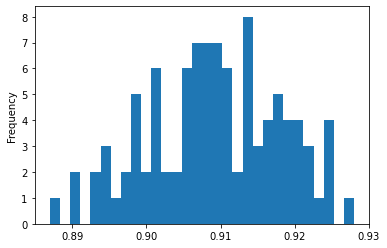

In [118]:
nb_df = pd.DataFrame(naps_stats, columns=['coverage', 'set_size', 'cc_set_size', 'sscv'])
nb_df['coverage'].plot(kind='hist', bins=30)
nb_df.describe()

,coverage,set_size,cc_set_size,sscv
count,100.00000,100.000000,100.000000,100.000000
mean,0.91049,1.694450,1.753975,0.058301
std,0.00898,0.041263,0.043803,0.014491
min,0.87600,1.594000,1.669189,0.023729
25%,0.90475,1.664500,1.725379,0.048319
50%,0.91000,1.696000,1.756565,0.058973
75%,0.91500,1.727250,1.782099,0.068909
max,0.93100,1.805000,1.863341,0.100000


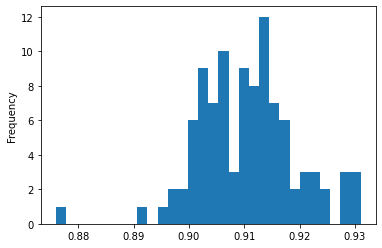

In [119]:
nb_df = pd.DataFrame(napsl_stats, columns=['coverage', 'set_size', 'cc_set_size', 'sscv'])
nb_df['coverage'].plot(kind='hist', bins=30)
nb_df.describe()

,coverage,set_size,cc_set_size,sscv
count,100.000000,100.000000,100.000000,100.000000
mean,0.908080,1.696210,1.754030,0.053006
std,0.008548,0.042569,0.044297,0.015180
min,0.887000,1.598000,1.646995,0.020000
25%,0.903000,1.670000,1.725746,0.043396
50%,0.908000,1.699500,1.753169,0.052254
75%,0.915000,1.730000,1.788980,0.062703
max,0.925000,1.827000,1.883822,0.091150


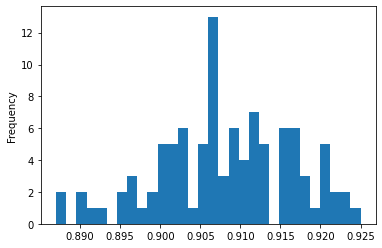

In [120]:
nb_df = pd.DataFrame(napsg_stats, columns=['coverage', 'set_size', 'cc_set_size', 'sscv'])
nb_df['coverage'].plot(kind='hist', bins=30)
nb_df.describe()

,coverage,set_size,cc_set_size,sscv
count,100.000000,100.000000,100.000000,100.000000
mean,0.907990,1.734310,1.782698,0.057595
std,0.009514,0.044552,0.047572,0.018307
min,0.878000,1.625000,1.680000,0.005882
25%,0.901000,1.701750,1.750067,0.041392
50%,0.907000,1.734000,1.780042,0.059179
75%,0.913250,1.771250,1.823254,0.071223
max,0.928000,1.834000,1.879691,0.100000


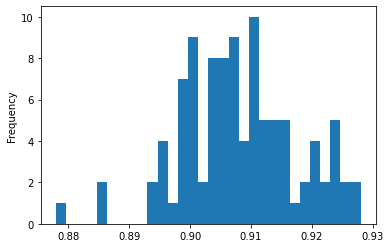

In [121]:
full_df = pd.DataFrame(full_stats, columns=['coverage', 'set_size', 'cc_set_size', 'sscv'])
full_df['coverage'].plot(kind='hist', bins=30)
full_df.describe()

In [122]:
from random import sample
## Split the test nodes into non-overlapping neighbourhoods
def split_into_neighbourhoods(test_nodes):
    test_subgraph = G.subgraph(test_nodes).copy()
    nbhds = []
    while test_subgraph.number_of_nodes() > 0:
        root = sample(list(test_subgraph.nodes()), 1)[0]
        nbhd_nodes = list(nx.single_source_shortest_path_length(test_subgraph, root, cutoff=2).keys())
        nbhds.append(nbhd_nodes)
        test_subgraph.remove_nodes_from(nbhd_nodes)
    return sorted(nbhds, key=lambda x: len(x), reverse=True)[:5]


In [123]:
aps_nccvs = []
naps_nccvs = []
napsl_nccvs = []
napsg_nccvs = []
for k in tqdm(range(n_trials)):
    np.random.shuffle(lcc_nodes)
    n_calib = len(lcc_nodes) // 2
    calib_nodes = lcc_nodes[:n_calib]
    test_nodes = lcc_nodes[n_calib:]

    ## Calibrate the regular CP on calibration nodes and make predictions on test nodes
    quantile = calibrate(preds.loc[calib_nodes].values,
                         np.squeeze(test_y.loc[calib_nodes].values), alpha)
    sets_full = pd.Series(predict(preds.loc[test_nodes].values, quantile), index=test_nodes)
    nbhds = split_into_neighbourhoods(test_nodes)
    aps_nb_coverages = []
    naps_nb_coverages = []
    napsl_nb_coverages = []
    napsg_nb_coverages = []

    for nbhd in nbhds:
        aps_nb_coverages.append(np.mean([test_y.loc[node].item() in sets_full[node] for node in nbhd]))
        naps_nb_coverages.append(naps_sets.loc[nbhd, 'covers'].mean())
        napsl_nb_coverages.append(napsl_sets.loc[nbhd, 'covers'].mean())
        napsg_nb_coverages.append(napsg_sets.loc[nbhd, 'covers'].mean())

    aps_nccv = max(np.abs(np.array(aps_nb_coverages) - (1 - alpha)))
    naps_nccv = max(np.abs(np.array(naps_nb_coverages) - (1 - alpha)))
    napsl_nccv = max(np.abs(np.array(napsl_nb_coverages) - (1 - alpha)))
    napsg_nccv = max(np.abs(np.array(napsg_nb_coverages) - (1 - alpha)))

    aps_nccvs.append(aps_nccv)
    naps_nccvs.append(naps_nccv)
    napsl_nccvs.append(napsl_nccv)
    napsg_nccvs.append(napsg_nccv)

  0%|          | 0/100 [00:00<?, ?it/s]

In [124]:
pd.DataFrame(aps_nccvs).describe()

,0
count,100.000000
mean,0.146290
std,0.092769
min,0.046328
25%,0.074657
50%,0.102878
75%,0.213246
max,0.414085


In [125]:
pd.DataFrame(naps_nccvs).describe()

,0
count,100.000000
mean,0.057666
std,0.023515
min,0.021795
25%,0.042560
50%,0.056105
75%,0.066457
max,0.133083


In [126]:
pd.DataFrame(napsl_nccvs).describe()

,0
count,100.000000
mean,0.052486
std,0.019174
min,0.016667
25%,0.036272
50%,0.053338
75%,0.063974
max,0.119048


In [127]:
pd.DataFrame(napsg_nccvs).describe()

,0
count,100.000000
mean,0.056632
std,0.021567
min,0.025000
25%,0.042397
50%,0.050138
75%,0.068182
max,0.133333
